# Downloading the data

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-11-15 17:36:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.176, 172.217.12.240, 172.217.9.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   156MB/s    in 0.9s    

2020-11-15 17:36:28 (156 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-11-15 17:36:28--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.9.208, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114801

In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [3]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse32-9.png', 'horse20-0.png', 'horse23-3.png', 'horse10-2.png', 'horse16-4.png', 'horse01-1.png', 'horse02-7.png', 'horse31-4.png', 'horse04-3.png', 'horse49-1.png']
['human05-09.png', 'human10-10.png', 'human15-22.png', 'human16-29.png', 'human04-08.png', 'human01-05.png', 'human05-15.png', 'human09-27.png', 'human16-21.png', 'human06-08.png']


In [5]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

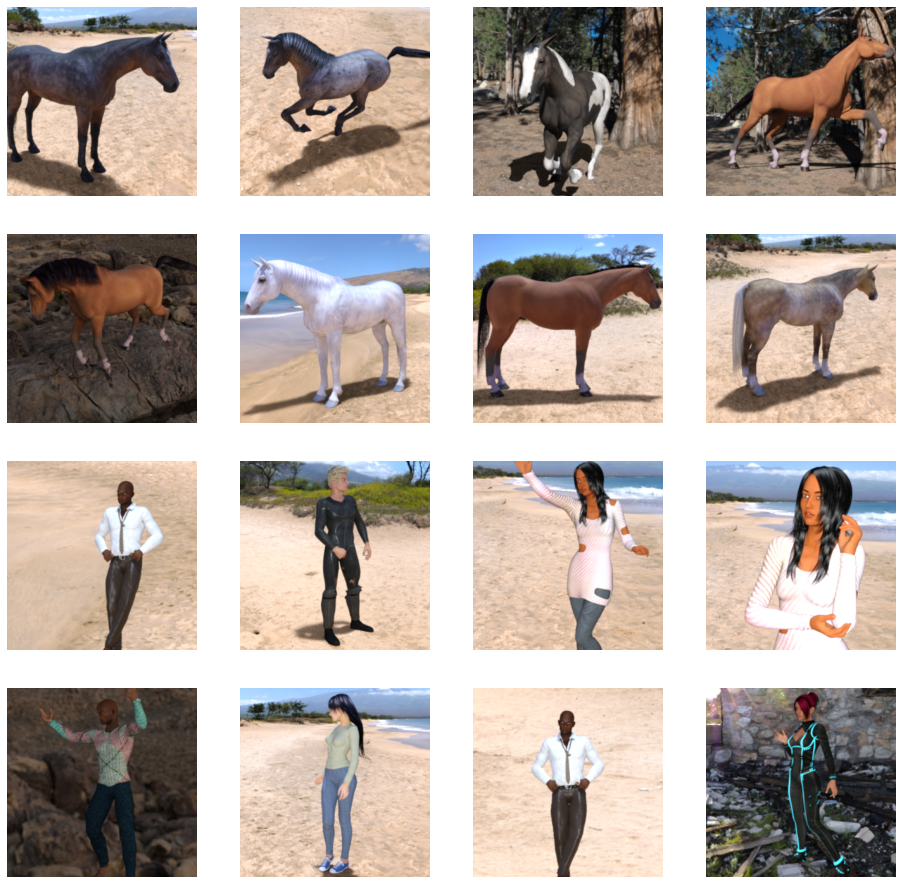

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Imports

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms

import numpy as np

# Define functions

In [9]:
def validate(model, loss_fn, test_data, device=torch.device('cpu')):
    loss_sum = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_data:
            out = model(images.to(device))
            loss_sum += loss_fn(out, labels.to(device).unsqueeze(1).type_as(out)).item()
            predicted = np.round(torch.sigmoid(out.data).cpu())
            total += images.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    return loss_sum, correct / total

In [10]:
def fit(model, optimizer, loss_fn, train_data, val_data, device=torch.device('cpu'), epochs=5):
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        loss_sum = 0
        correct = 0
        total = 0
        for images, labels in train_data:
            optimizer.zero_grad()
            out = model(images.to(device))
            loss = loss_fn(out, labels.to(device).unsqueeze(1).type_as(out))
            loss.backward()
            optimizer.step()

            predicted = np.round(torch.sigmoid(out.data).cpu())
            total += images.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            loss_sum += loss.item()
        
        val_loss, val_acc = validate(model, loss_fn, val_data, device=device)
        train_acc = correct / total
        print(f'loss: {loss_sum:0.4f} - acc: {train_acc:0.4f} - val_loss: {val_loss:0.4f} - val_accuracy: {val_acc:0.4f}')

# Constants definition

In [11]:
EPOCHS = 15
IMAGE_SIZE = 300
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
NUM_WORKERS = 1

# Providing the data

In [12]:
# use GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [13]:
transform = transforms.ToTensor()
train_dataset = datasets.ImageFolder('/tmp/horse-or-human/', transform=transform)
val_dataset = datasets.ImageFolder('/tmp/validation-horse-or-human/', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Fit and Evaluate the Neural Network

In [14]:
model = nn.Sequential(
    nn.Conv2d(3, 16, (3,3)),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(16, 32, (3,3)),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(32, 64, (3,3)),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Flatten(),
    nn.Linear(78400, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
).to(DEVICE)

print(model)

optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCEWithLogitsLoss()

fit(model, optimizer, loss_fn, train_loader, val_loader, device=DEVICE, epochs=EPOCHS)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=78400, out_features=512, bias=True)
  (11): ReLU()
  (12): Linear(in_features=512, out_features=1, bias=True)
)
Epoch 1/15
loss: 202.7460 - acc: 0.5492 - val_loss: 4.7093 - val_accuracy: 0.8477
Epoch 2/15
loss: 16.3261 - acc: 0.7712 - val_loss: 17.9514 - val_accuracy: 0.5000
Epoch 3/15
loss: 10.9278 - acc: 0.8705 - val_loss: 3.7469 - val_accuracy: 0.7148
Epoch 4/15
loss: 5.6156 - acc: 0.9299 - val_loss: 5.4560 - val_accuracy: 0.8

# Running the model

In [15]:
from google.colab import files
from PIL import Image
import torch
import torchvision.transforms.functional as functional

def run(model, image_size, device=torch.device('cpu')):
    uploaded = files.upload()

    for fn in uploaded.keys():
        # predicting images
        path = '/content/' + fn
        img = Image.open(path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(), 
        ])
        x = transform(img).unsqueeze(0)

        with torch.no_grad():
            out = model(x.to(device))
            classes = torch.sigmoid(out.data).cpu()
            print(classes[0])
            if classes[0] > 0.5:
                print(fn + " is a human")
            else:
                print(fn + " is a horse")

run(model, IMAGE_SIZE, device=DEVICE)

Saving valhuman01-00.png to valhuman01-00.png
Saving horse1-000.png to horse1-000.png
tensor([1.0000])
valhuman01-00.png is a human
tensor([0.0053])
horse1-000.png is a horse


# Visualizing Inermediate Representations

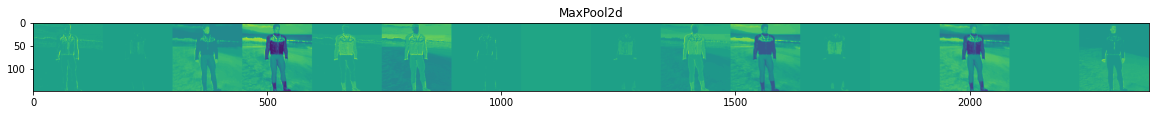

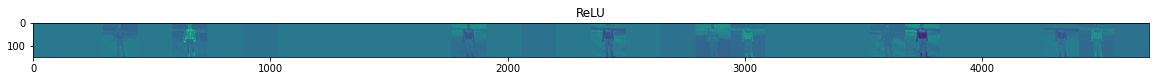

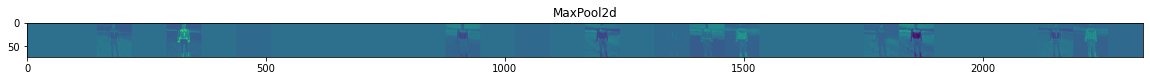

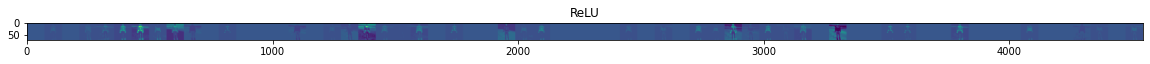

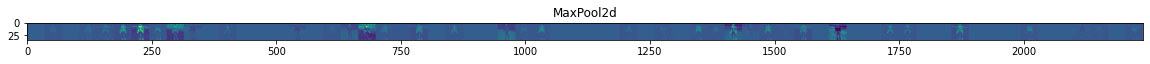

In [16]:
import numpy as np
import random
from PIL import Image
import torch
import torchvision.transforms.functional as functional

def plot_convolutions(model, image_size, device=torch.device('cpu')):
    def get_forward_hook(layer_name):
        def hook(model, input, output):
            n_features = output.shape[1]  # number of features in feature map
            # The feature map has shape (1, n_features, size, size)
            size = output.shape[2]
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))
            for i in range(n_features):
                # Postprocess the feature to make it visually palatable
                x = output.cpu()[0, i, :, :].detach().numpy()
                x -= x.mean()
                if (x > 0).all() :
                    x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                # We'll tile each filter into this big horizontal grid
                display_grid[:, i * size : (i + 1) * size] = x
            # Display the grid
            scale = 20. / n_features
            plt.figure(figsize=(scale * n_features, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
        return hook

    handles = [model[i].register_forward_hook(get_forward_hook(type(model[i]).__name__)) for i in (2, 4, 5, 7, 8)]

    horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
    human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
    img_path = random.choice(horse_img_files + human_img_files)

    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(), 
    ])
    x = transform(img).unsqueeze(0)

    with torch.no_grad():
        model(x.to(device))

    for h in handles:
        h.remove()

plot_convolutions(model, IMAGE_SIZE, device=DEVICE)

# Clean Up

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)